<center>
<a href="http://www.insa-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo-insa.jpg" style="float:left; max-width: 120px; display: inline" alt="INSA"/></a> 

<a href="http://wikistat.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/wikistat.jpg" style="max-width: 250px; display: inline"  alt="Wikistat"/></a>

<a href="http://www.math.univ-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo_imt.jpg" style="float:right; max-width: 200px; display: inline" alt="IMT"/> </a>
</center>

# [High Dimensional Statistics](https://github.com/wikistat/High-Dimensional-Statistics)

# [Reconnaissance d'Activité Humaine](https://github.com/wikistat/High-Dimensional-Statistics/tree/master/HumanActivityRecognition) ([*HAR*](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones)) en <a href="https://www.python.org/"><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/f8/Python_logo_and_wordmark.svg/390px-Python_logo_and_wordmark.svg.png" style="max-width: 120px; display: inline" alt="Python"/></a>  Troisième partie:  Detection d'anomalie

Ce notebook présente la partie détection d'anomalie sur les signaux bruts. Pour la prédiction, se référer au calepin suivant.

## Introduction

### Téléchargement des librairies

In [1]:
import pandas as pd
import numpy as np

# ACP
import sklearn.decomposition as sd
import sklearn.preprocessing as sp

# Hierarchical clustering
import scipy.cluster.hierarchy as sch
# LOF
import sklearn.neighbors as sn
# Isolation Forest
import sklearn.ensemble as se

# Plot et Display
import utils.illustration as uil
from IPython.display import display
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb
sb.set()
sb.set_style("whitegrid")

Variable

In [2]:
SIGNALS = [ "body_acc_x", "body_acc_y", "body_acc_z", "body_gyro_x", "body_gyro_y", "body_gyro_z"]
CMAP = plt.get_cmap("Set1")
ACTIVITY_DIC = {1 : "WALKING",
2 : "WALKING UPSTAIRS",
3 : "WALKING DOWNSTAIRS",
4 : "SITTING",
5 : "STANDING",
6 : "LAYING"}
COLOR_DIC = {v:CMAP(k-2) if v!="WALKING" else CMAP(10) for k,v in ACTIVITY_DIC.items()}

## Les données
### Téléchargement des données
Signaux

In [3]:
import utils.load as ul

#Multidimensional Data
X_train = ul.load_signals("train", SIGNALS)
Y_train_label = ul.load_y("train")
X_train_metier= ul.my_read_csv("train/X_train.txt").values


### Consititution des jeux de données avec anomalie

On construit un jeu de données constitué de 

   * `N_normal` signaux considérés comme normaux (associés au comportement *WALKING*).  
   * `N_anormal` signaux par type de signaux anormaux (*WALKING UPSTAIR*, *WALKING DOWNSTAIRS*, *SITTING*, *STANDING*, *LAYING*)


In [4]:
N_normal = 800
N_anormal = 2

# New Y Label
Y= np.hstack([np.repeat(1,N_normal)] + [np.repeat(i, N_anormal) for i in range(2,7)])
Y_label = np.array([ACTIVITY_DIC[y] for y in Y])
#New X Data
index_per_act = np.hstack([np.where(Y_train_label==1)[0][:N_normal]] + [np.where(Y_train_label==act)[0][:N_anormal] for act in range(2,7)])

X = X_train[index_per_act]
X_metier = X_train_metier[index_per_act]

Pour chaque type de signal, on affiche un echantillon des comportement normaux, ainsi que les différentes anomalies.

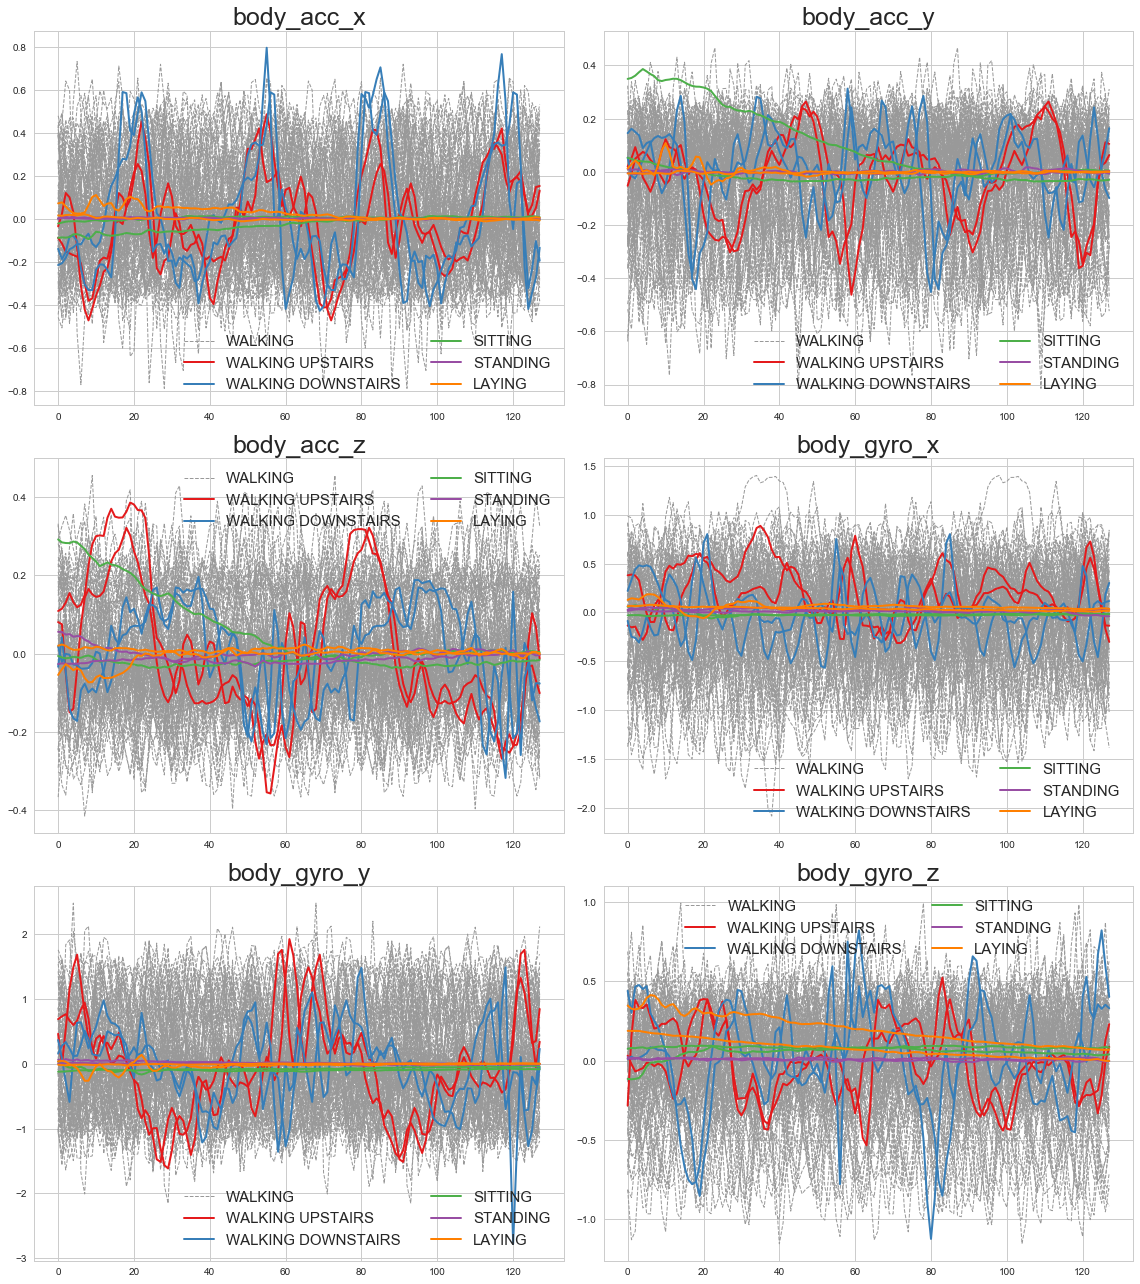

In [5]:
nb_sample_per_activity = dict([(v,100) if v=="WALKING" else (v,N_anormal) for k,v in ACTIVITY_DIC.items()])
linestyle_per_activity = dict([(v,"dashed") if v=="WALKING" else (v,"solid") for k,v in ACTIVITY_DIC.items()])
linewidth_per_activity = dict([(v,1) if v=="WALKING" else (v,2) for k,v in ACTIVITY_DIC.items()])

fig = plt.figure(figsize=(16,18))    
uil.plot_signaux(fig, X, Y_label, SIGNALS, COLOR_DIC, nb_sample_per_activity, 
             linestyle_per_activity, linewidth_per_activity, figdim1 = 3, figdim2 = 2, legend=True)


## Analyse en composante principale
###  Sur un Signal

In [6]:
isignal = 0
print("ACP on signal " + SIGNALS[isignal])
X_signal = np.vstack([x[:,isignal] for x in X])

acp = sd.PCA()
X_acp_signal = acp.fit_transform(sp.scale(X_signal))

ACP on signal body_acc_x


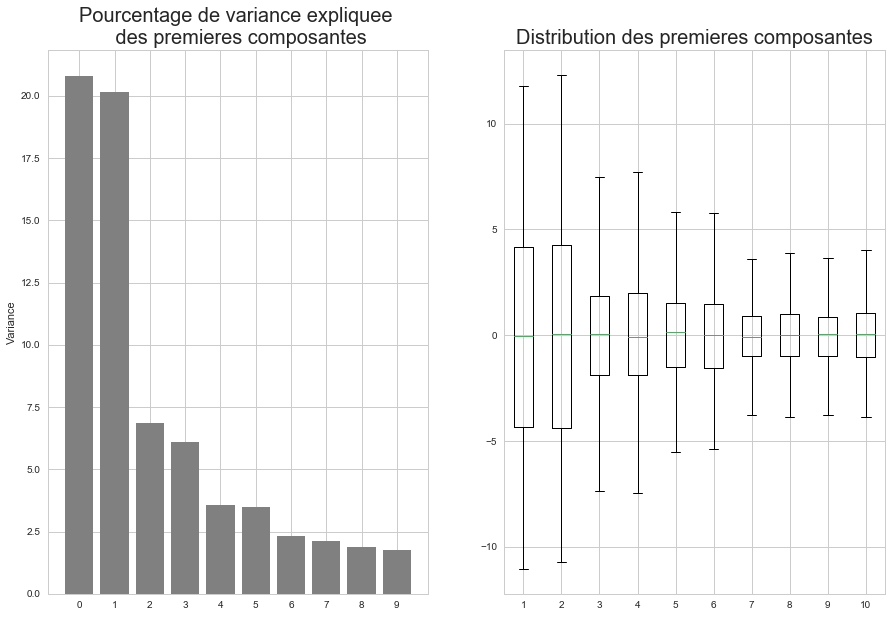

In [7]:
fig = plt.figure(figsize=(15,10))
uil.plot_variance_acp(fig, acp, X_acp_signal)

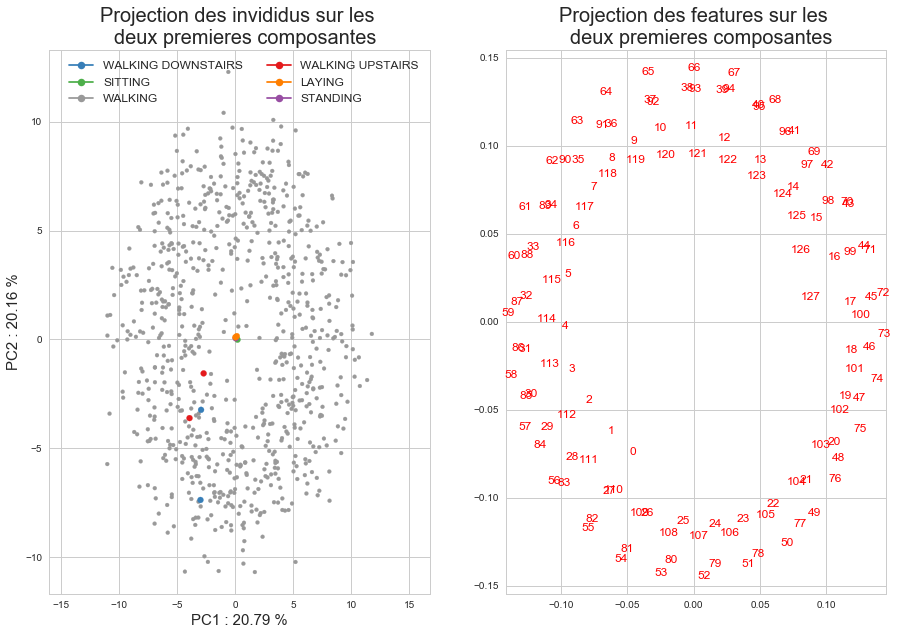

In [8]:
N = X.shape[0]
colors=[COLOR_DIC[y] for y in Y_label]
markersizes = [60 if y==1 else 140 for y in Y]
fig = plt.figure(figsize=(15,10))
uil.plot_projection_acp(fig, X_acp_signal, acp, colors=colors, markersizes = markersizes, color_dic=COLOR_DIC)

###  Sur Tous les signaux

In [9]:
X_signaux = np.vstack([x.reshape(128*6) for x in X])
acp = sd.PCA()
X_acp_signaux = acp.fit_transform(sp.scale(X_signaux))

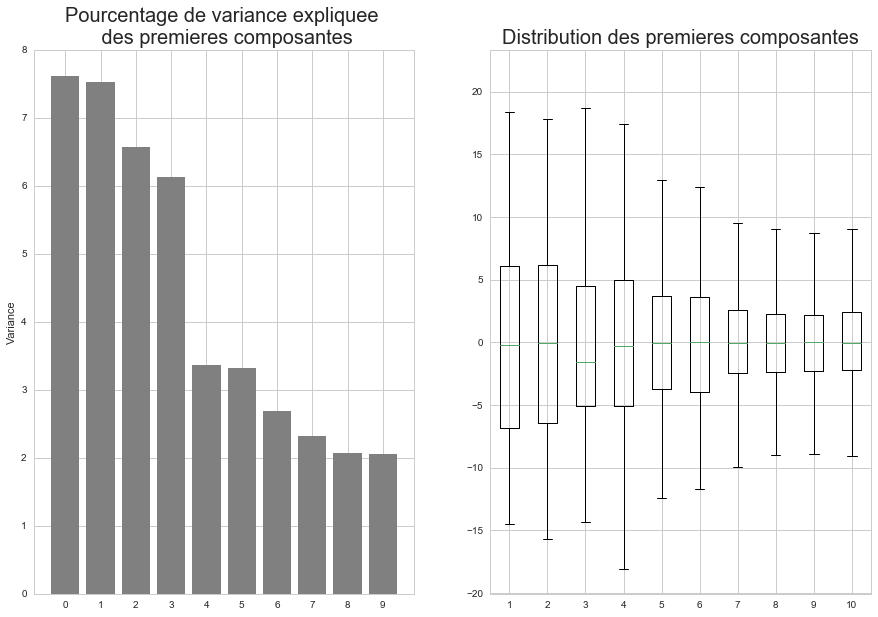

In [10]:
fig = plt.figure(figsize=(15,10))
uil.plot_variance_acp(fig, acp, X_acp_signaux)

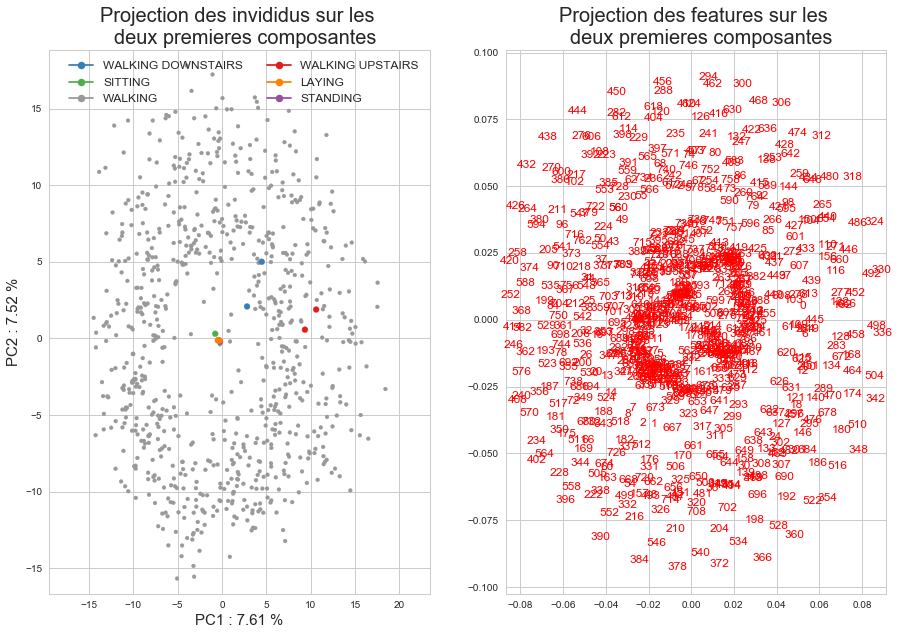

In [11]:
fig = plt.figure(figsize=(15,10))
uil.plot_projection_acp(fig, X_acp_signaux, acp, colors, markersizes, color_dic=COLOR_DIC)

### Sur les données métiers

In [12]:
acp = sd.PCA()
X_acp_metier = acp.fit_transform(sp.scale(X_metier))

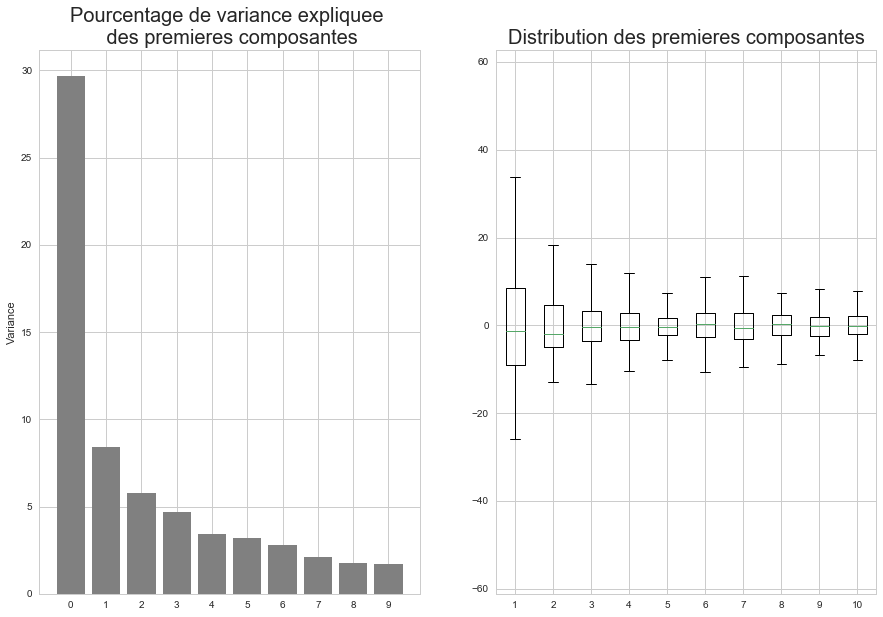

In [13]:
fig = plt.figure(figsize=(15,10))
uil.plot_variance_acp(fig, acp, X_acp_metier)

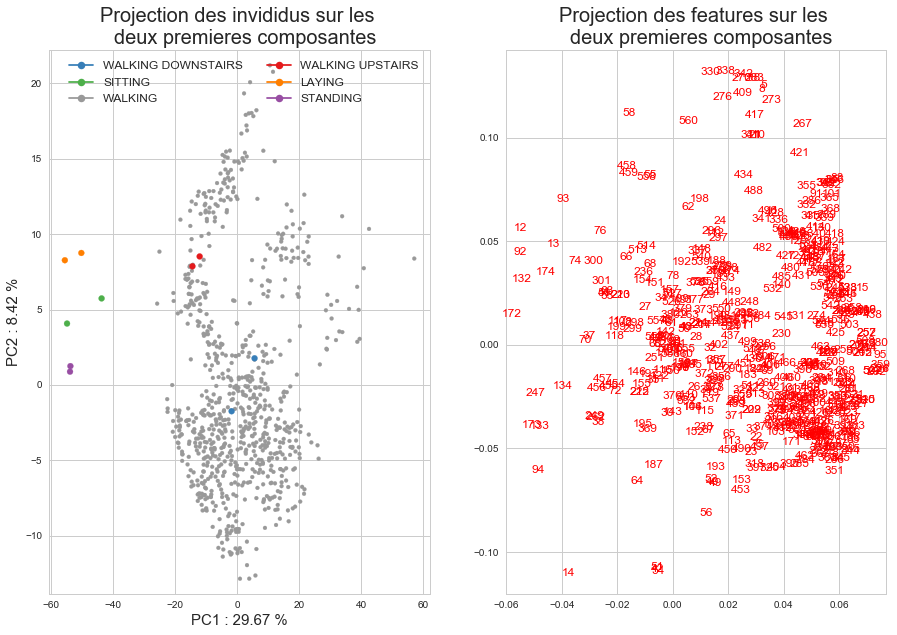

In [14]:
fig = plt.figure(figsize=(15,10))
uil.plot_projection_acp(fig, X_acp_metier, acp, colors, markersizes, color_dic=COLOR_DIC)

## TODO :  Ondelette


## Détection d'anomalies

### Classification Ascendente Hiérarchique

In [15]:
Z = sch.linkage(X_signal, 'single')
C = np.array([c[0] for c in sch.cut_tree(Z,4)])

CT_HCA = pd.DataFrame(list(zip(C,Y_label)), columns=["pred","Anomaly"])
display(pd.crosstab(CT_HCA.pred, CT_HCA.Anomaly))

Anomaly,LAYING,SITTING,STANDING,WALKING,WALKING DOWNSTAIRS,WALKING UPSTAIRS
pred,,,,,,
0,2,2,2,795,2,2
1,0,0,0,3,0,0
2,0,0,0,1,0,0
3,0,0,0,1,0,0


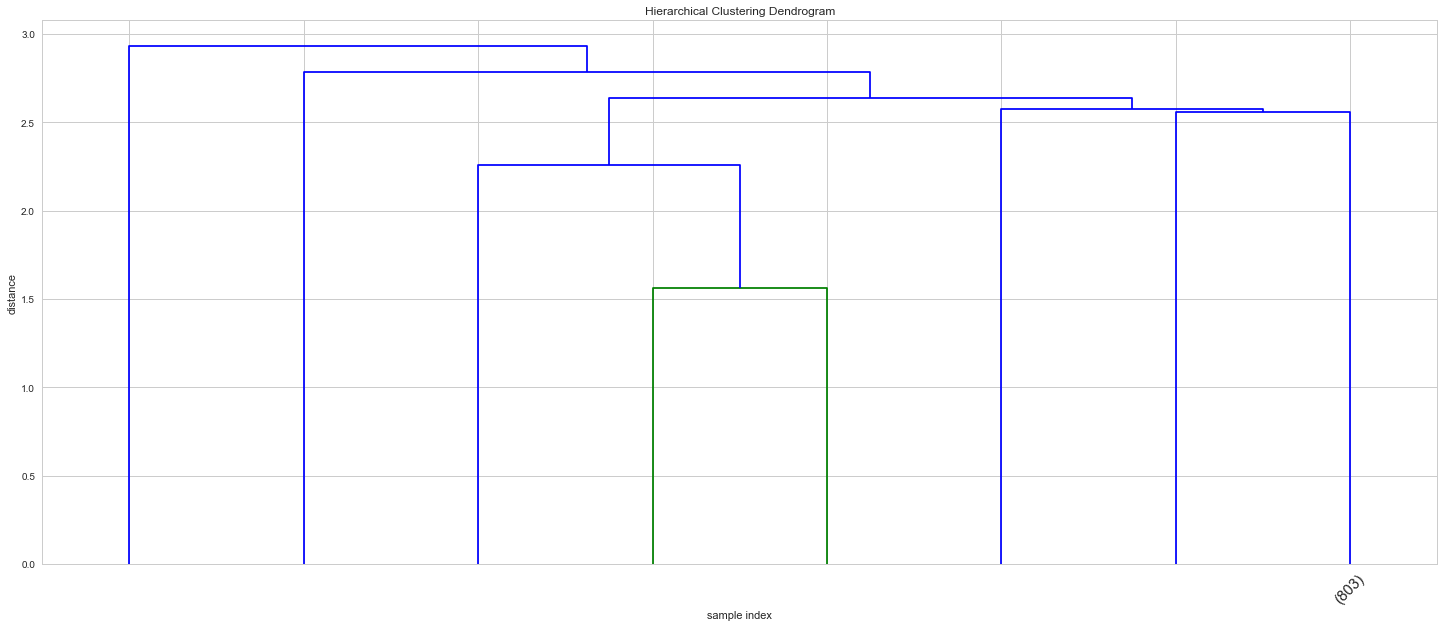

In [16]:
LABELS = ["" if y=="WALKING" else y for y in Y_label]
fig = plt.figure(figsize=(25, 10))
sch.dendrogram( Z, p=4, leaf_rotation=45.,leaf_font_size=15,labels=LABELS, truncate_mode="level"  # font size for the x axis labels
)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')

ax =fig.get_axes()[0]
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    if lbl.get_text() in COLOR_DIC:
        lbl.set_color(COLOR_DIC[lbl.get_text()])


plt.show()

### One class SVM

In [17]:
import sklearn.svm as ssvm
OCS = ssvm.OneClassSVM(kernel="rbf", nu=0.02)

OCS.fit(X_acp_signal[:,:2])
pred = OCS.predict(X_acp_signal[:,:2])

CT_svm = pd.DataFrame(list(zip(pred,Y_label)), columns=["pred","Anomaly"])
display(pd.crosstab(CT_svm.pred, CT_svm.Anomaly))

Anomaly,LAYING,SITTING,STANDING,WALKING,WALKING DOWNSTAIRS,WALKING UPSTAIRS
pred,,,,,,
-1,0,0,0,272,0,1
1,2,2,2,528,2,1


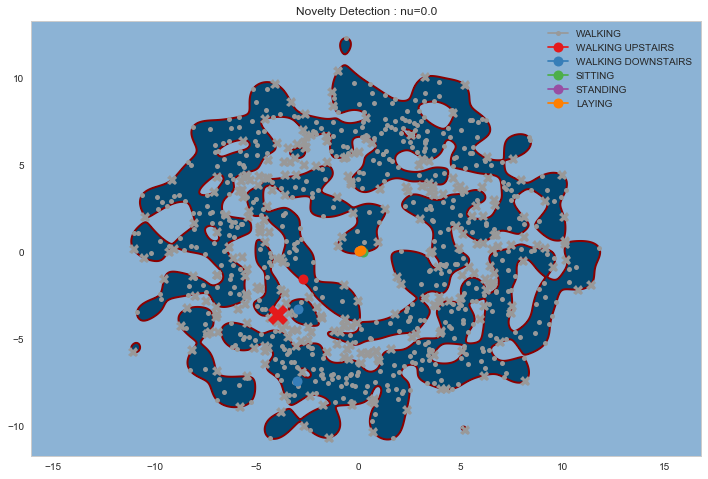

In [18]:
X_acp = X_acp_signal
nu = 0.02

# fit the model
clf = ssvm.OneClassSVM(kernel="rbf",nu=nu)
clf.fit(X_acp[:,:2])
y_pred_train = clf.predict(X_acp[:,:2])


fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1)

markersizes = [10 if y==1 else 20 for y in Y]
labels = [""] * N 
for il, l in [(np.where(Y_label==y)[0][0],y) for y in set(Y_label)]:
    labels[il] = l

uil.plot_decision_function(fig, ax, clf, X_acp, y_pred_train, colors=colors, labels = labels, markersizes=markersizes)
ax.set_title("Novelty Detection : nu=%.1f" %nu)


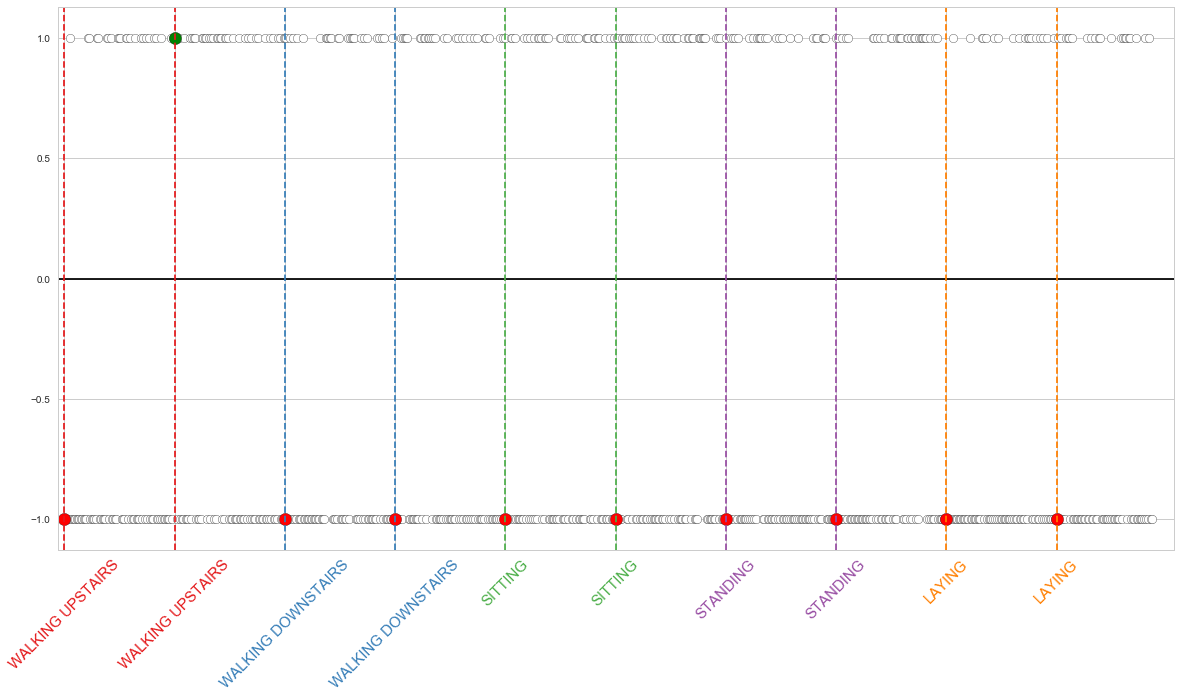

In [19]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,1,1)
uil.plot_detection_result(fig, ax, CT_svm, COLOR_DIC, normal_behaviour="WALKING")


### Local Outlier Factor

In [20]:
contamination=0.02
metric = "euclidean"
n_neighbors = 5
clf = sn.LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination, metric=metric)
y_pred = clf.fit_predict(X_signal)

CT_lof = pd.DataFrame(list(zip(y_pred,Y_label)), columns=["pred","Anomaly"])
display(pd.crosstab(CT_lof.pred, CT_lof.Anomaly))


Anomaly,LAYING,SITTING,STANDING,WALKING,WALKING DOWNSTAIRS,WALKING UPSTAIRS
pred,,,,,,
-1,0,0,0,15,2,0
1,2,2,2,785,0,2


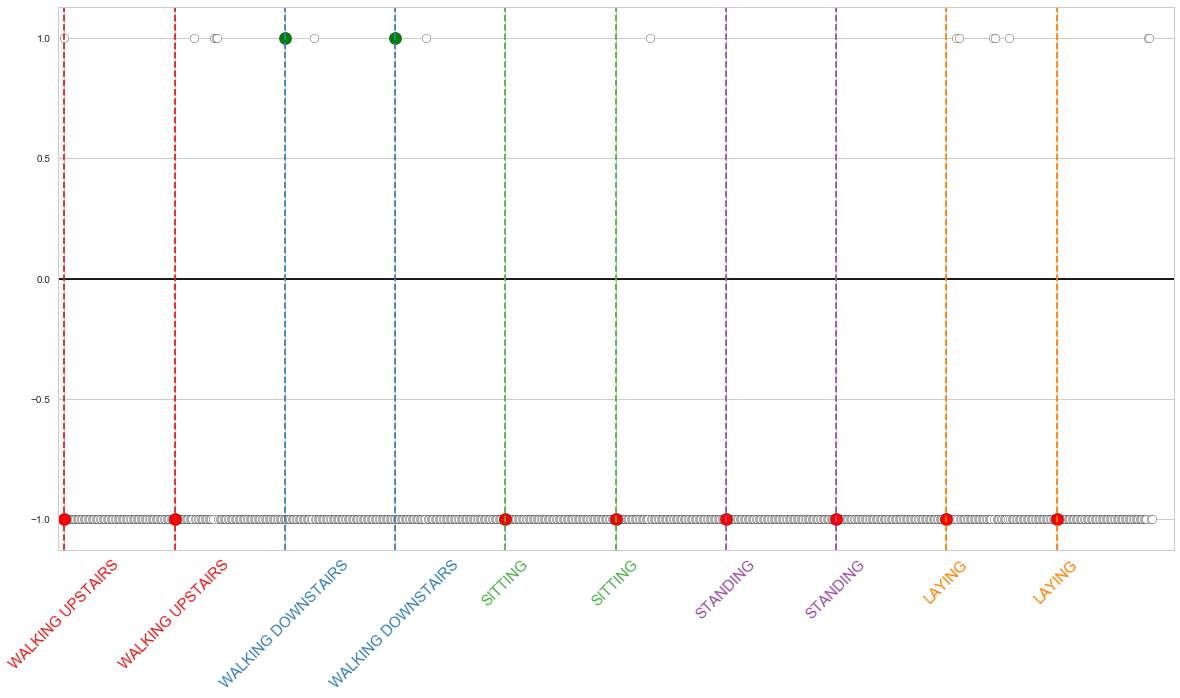

In [21]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,1,1)
uil.plot_detection_result(fig, ax, CT_lof, COLOR_DIC, normal_behaviour="WALKING")


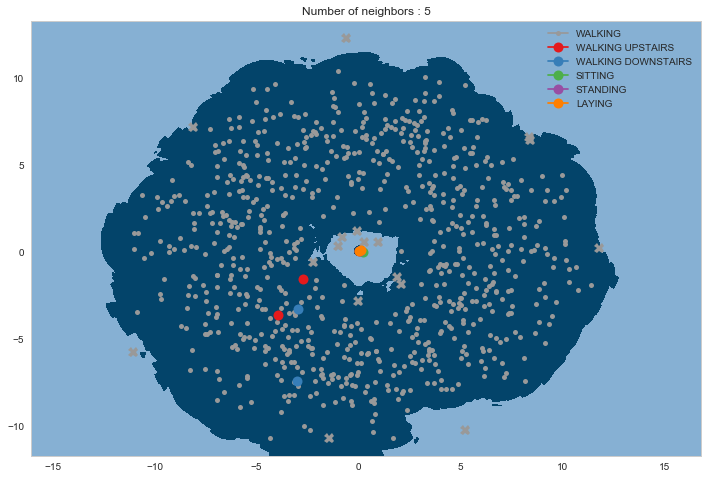

In [22]:
X_acp = X_acp_signal
n_neighbors = 5

# fit the model
clf = sn.LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination, metric = metric)
y_pred = clf.fit_predict(X_acp[:,:2])

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1)
uil.plot_decision_function(fig, ax, clf, X_acp, y_pred, method_name="LOF", colors=colors, labels = labels, markersizes=markersizes)
ax.set_title("Number of neighbors : %d" %n_neighbors)


## Isolation Forest

In [23]:
clf = se.IsolationForest(n_estimators=100, contamination=0.02, bootstrap=True, n_jobs=-1)
clf.fit(X_acp_metier)
y_pred = clf.predict(X_acp_metier)

CT_IF = pd.DataFrame(list(zip(y_pred,Y_label)), columns=["pred","Anomaly"])
display(pd.crosstab(CT_IF.pred, CT_IF.Anomaly))

Anomaly,LAYING,SITTING,STANDING,WALKING,WALKING DOWNSTAIRS,WALKING UPSTAIRS
pred,,,,,,
-1,0,1,0,16,0,0
1,2,1,2,784,2,2


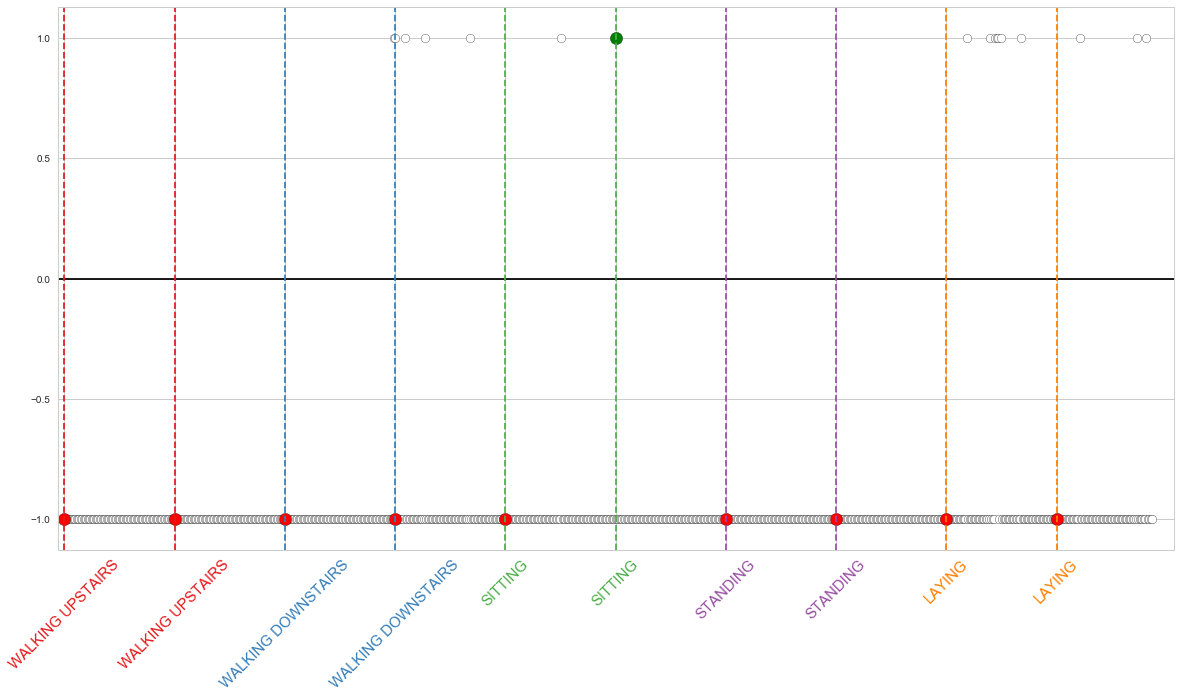

In [24]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,1,1)
uil.plot_detection_result(fig, ax, CT_IF, COLOR_DIC, normal_behaviour="WALKING")


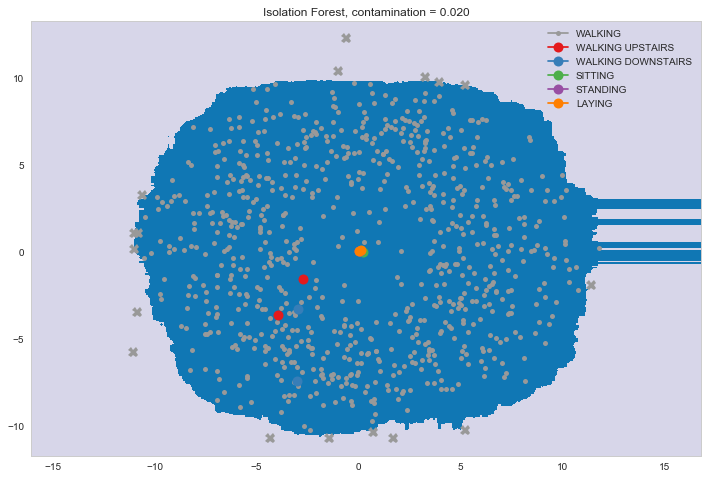

In [25]:
X_acp = X_acp_signal

contamination=0.02
clf = se.IsolationForest(n_estimators=100, contamination=contamination, bootstrap=True, n_jobs=-1)
clf.fit(X_acp[:,:2])
y_pred = clf.predict(X_acp[:,:2])

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1)
uil.plot_decision_function(fig, ax, clf, X_acp, y_pred, method_name = "IF", colors=colors, labels = labels, markersizes=markersizes)
ax.set_title("Isolation Forest, contamination = %.3f" %contamination)
